In [7]:
!pip install qiskit qiskit-aer matplotlib numpy pylatexenc -q

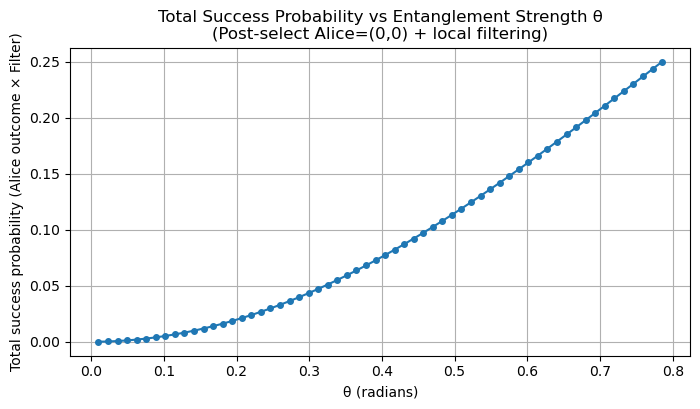

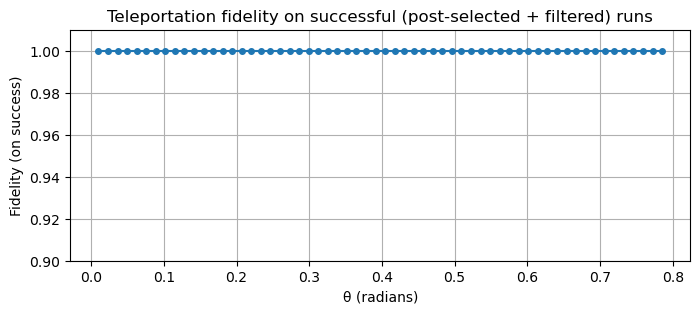

theta=0.010, total success prob=0.0000, filter prob=0.0002, fidelity_on_success=1.000000
theta=0.141, total success prob=0.0099, filter prob=0.0397, fidelity_on_success=1.000000
theta=0.404, total success prob=0.0774, filter prob=0.3094, fidelity_on_success=1.000000
theta=0.785, total success prob=0.2500, filter prob=1.0000, fidelity_on_success=1.000000


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, partial_trace

def normalize(vec):
    n = np.linalg.norm(vec)
    return vec / n if n>0 else vec

def create_input_state(alpha, beta):
    # normalized 1-qubit statevector (2-vector)
    v = np.array([alpha, beta], dtype=complex)
    return normalize(v)

def entangled_pair_state(theta):

    c, s = np.cos(theta), np.sin(theta)

    svec = np.zeros(4, dtype=complex)
    svec[0] = c
    svec[3] = s
    return svec

def full_initial_state(psi, theta):

    phi = entangled_pair_state(theta)
    full = np.kron(psi, phi)
    return normalize(full)

def apply_teleport_ops(full_state):

    CNOT01 = np.zeros((8,8), dtype=complex)
    for i in range(8):
        b = format(i, '03b')
        q0,q1,q2 = int(b[0]), int(b[1]), int(b[2])
        q1p = q1 ^ q0   # flip q1 if q0==1
        j = q0*4 + q1p*2 + q2
        CNOT01[j,i] = 1
    # H on qubit 0
    H = (1/np.sqrt(2)) * np.array([[1,1],[1,-1]])
    H0 = np.kron(np.kron(H, np.eye(2)), np.eye(2))
    state = CNOT01 @ full_state
    state = H0 @ state
    return state


def project_on_alice(state_vec, m0, m1):

    bob_un = np.zeros(2, dtype=complex)
    prob = 0.0
    for q2 in (0,1):
        idx = m0*4 + m1*2 + q2
        amp = state_vec[idx]
        bob_un[q2] = amp
        prob += abs(amp)**2
    return bob_un, prob


def filtering_operator(theta):
    c, s = np.cos(theta), np.sin(theta)
    k = min(c, s)
    f0 = k / c if c!=0 else 0.0
    f1 = k / s if s!=0 else 0.0

    A = np.array([[f0, 0.0],[0.0, f1]], dtype=complex)
    return A

def simulate_protocol(alpha, beta, theta):
    psi = create_input_state(alpha, beta)
    full = full_initial_state(psi, theta)
    after_ops = apply_teleport_ops(full)


    m0, m1 = 0, 0
    bob_un, prob_m = project_on_alice(after_ops, m0, m1)
    if prob_m == 0:
        return {
            'prob_measure': 0.0,
            'prob_filter': 0.0,
            'prob_success_total': 0.0,
            'fidelity_success': 0.0
        }
    bob_state_before = bob_un / np.linalg.norm(bob_un)
    A = filtering_operator(theta)

    AA = A.conj().T @ A
    prob_filter = float(np.vdot(bob_state_before, AA @ bob_state_before).real)

    bob_after_un = A @ bob_state_before
    if np.linalg.norm(bob_after_un) == 0:
        fidelity_success = 0.0
    else:
        bob_after = bob_after_un / np.linalg.norm(bob_after_un)

        fidelity_success = float(np.abs(np.vdot(psi, bob_after))**2)


    prob_success_total = prob_m * prob_filter

    return {
        'prob_measure': prob_m,
        'prob_filter': prob_filter,
        'prob_success_total': prob_success_total,
        'fidelity_success': fidelity_success
    }


alpha, beta = 1.0, 1.0j
thetas = np.linspace(0.01, np.pi/4, 60)

probs_total = []
probs_filter = []
fids = []
for t in thetas:
    res = simulate_protocol(alpha, beta, t)
    probs_total.append(res['prob_success_total'])
    probs_filter.append(res['prob_filter'])
    fids.append(res['fidelity_success'])

plt.figure(figsize=(8,4))
plt.plot(thetas, probs_total, '-o', markersize=4)
plt.title("Total Success Probability vs Entanglement Strength θ\n(Post-select Alice=(0,0) + local filtering)")
plt.xlabel("θ (radians)")
plt.ylabel("Total success probability (Alice outcome × Filter)")
plt.grid(True)
plt.show()


plt.figure(figsize=(8,3))
plt.plot(thetas, fids, '-o', markersize=4)
plt.title("Teleportation fidelity on successful (post-selected + filtered) runs")
plt.xlabel("θ (radians)")
plt.ylabel("Fidelity (on success)")
plt.ylim(0.9, 1.01)
plt.grid(True)
plt.show()

for i in [0, 10, 30, -1]:
    print(f"theta={thetas[i]:.3f}, total success prob={probs_total[i]:.4f}, filter prob={probs_filter[i]:.4f}, fidelity_on_success={fids[i]:.6f}")


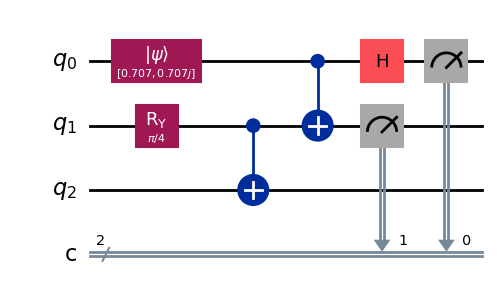

In [15]:
%matplotlib inline

from qiskit import QuantumCircuit


theta = np.pi / 8
vec = np.array([alpha, beta], dtype=complex)
vec /= np.linalg.norm(vec)

qc = QuantumCircuit(3, 2)
qc.initialize(vec, 0)
qc.ry(2*theta, 1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.h(0)
qc.measure([0,1], [0,1])

fig = qc.draw('mpl')
from IPython.display import display
display(fig)


